# Roadmap

In [1]:
%load_ext autoreload
%autoreload 2
import autoreload

## 1. Load data

In [2]:
from functions import load_data
data_df = load_data('data/time_series.xlsx')
data_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 292 entries, 2012-04-08 to 2017-11-05
Columns: 1833 entries, 012 to TRUHONE
dtypes: int64(1833)
memory usage: 4.1 MB


## 2. Train-Test Split

In [3]:
# splitting into training and testing sets setting aside last year for testing
from functions import ts_train_test_split

train_df, test_df = ts_train_test_split(data_df, 52)

Observations: 292
Training Observations: 240
Testing Observations: 52


In [ ]:
# DO NOT TOUCH Test Set!!!! Data snooping no-no

## Make Groups

In [4]:
# make a list of column names
product_SKUs = list(train_df.columns.values)
len(product_SKUs)

1833

In [5]:
# non_active products
# defined as products that have not moved in n_weeks time periods
# we will start with n_weeks 52 (1 year)

from datetime import datetime

def identify_non_active(dataframe, product_list, year, month, day):
    last_tp = (dataframe[datetime(year, month, day):])

    non_active = []
    for product in product_list:
        if last_tp[product].sum() == 0:
            non_active.append(product)
    return non_active

non_active = identify_non_active(train_df, product_SKUs, 2015, 11, 4)
len(non_active)

472

In [6]:
# 1833 products, 472 non_active, leaving 1361, new?
len(product_SKUs) - len(non_active)

1361

In [7]:
# new products 
train_df[:datetime(2014, 5, 3)]

def identify_new_product(dataframe, product_list, year, month, day):
    previous_tp = (dataframe[:datetime(year, month, day)])
    last_tp = (dataframe[datetime(year, month, day):])

    new_products = []
    for product in product_list:
        if previous_tp[product].sum() == 0 and last_tp[product].sum() !=0:
            new_products.append(product)
    return new_products
new_products = identify_new_product(train_df, product_SKUs, 2015, 11, 4)
len(new_products)

138

In [8]:
# 1833 products, 472 non_active, 138 new, leaving 1223, intermittent?
len(product_SKUs) - len(non_active) - len(new_products)

1223

In [9]:
# intermittent demand
# iterate over last year, if n consecutive values = 0, but sum != 0 
# (they are all active so no need to check), it's intermittent
def identify_intermittent_product(dataframe, product_list, non_active, year, month, day, n):
    last_tp = (dataframe[datetime(year, month, day):])

    products = [value for value in product_SKUs if value not in non_active]
    intermittent = products.copy()
    
    for product in products:
        if last_tp[product].rolling(n).sum().dropna().nonzero():
            intermittent.remove(product)
    return intermittent
    
my_list = identify_intermittent_product(train_df, product_SKUs, non_active, 2015, 11, 4, 2)
len(my_list)

0

In [ ]:
# 1223 products k=15
1223/15

In [10]:
# create leftover dataset for dynamic time warping
col_names = [value for value in product_SKUs if value not in non_active and value not in new_products]
len(col_names)
products = train_df[col_names]
products.head()

,017,0300ST1550-1,0300ST245-1,0300ST320-1,0300ST320-2,0300ST320-3,0300ST365-1,0300ST365-2,0300ST365-3,0300ST450-1,...,9920-1,9920-2,9920-3,9920-4,9920-5,9920-6,9920-7,9997-25,HW220D15,TRUHONE
EntDate,,,,,,,,,,,,,,,,,,,,,
2012-04-08,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-04-15,0,0,0,0,0,0,1,0,1,2,...,21,20,19,7,166,98,0,0,0,0
2012-04-22,0,0,0,0,0,0,0,0,0,0,...,114,41,15,10,207,87,0,0,0,0
2012-04-29,0,0,0,0,0,0,200,0,0,0,...,43,38,44,13,101,21,10,0,0,0
2012-05-06,0,0,0,0,0,0,0,0,0,0,...,154,29,47,21,75,43,0,0,0,0


## Dynamic Time Warping

In [21]:
# pick three products to experiment
t1=train_df['03108627CC']
t2=train_df['9920-2']
t3=train_df['TRUHONE']

In [22]:
from math import sqrt

def euclid_dist(t1,t2):
    return sqrt(sum((t1-t2)**2))
one_to_2 = euclid_dist(t1,t2)
one_to_3 = euclid_dist(t1,t3)
two_to_3 = euclid_dist(t2,t3)
one_to_2, one_to_3, two_to_3

(2007.394829125551, 7.615773105863909, 2004.8481239236053)

In [8]:
def DTWDistance(s1, s2):
    DTW={}

    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return sqrt(DTW[len(s1)-1, len(s2)-1])

In [ ]:
one_two = DTWDistance(t1,t2)
one_three = DTWDistance(t1,t3)
two_three = DTWDistance(t2,t3)
one_two, one_three, two_three

In [9]:
# w is the window of time period
def DTWDistance(s1, s2, w):
    DTW={}

    w = max(w, abs(len(s1)-len(s2)))

    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return sqrt(DTW[len(s1)-1, len(s2)-1])

In [ ]:
one_two = DTWDistance(t1,t2, 4)
one_three = DTWDistance(t1,t3, 4)
two_three = DTWDistance(t2,t3, 4)
one_two, one_three, two_three

In [ ]:
one_two = DTWDistance(t1,t2, 12)
one_three = DTWDistance(t1,t3, 12)
two_three = DTWDistance(t2,t3, 12)
one_two, one_three, two_three

In [10]:
# r is reach
def LB_Keogh(s1,s2,r):
    LB_sum=0
    for ind,i in enumerate(s1):

        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])

        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2

    return sqrt(LB_sum)

In [ ]:
one_two = LB_Keogh(t1,t2, 12)
one_three = LB_Keogh(t1,t3, 12)
two_three = LB_Keogh(t2,t3, 12)
one_two, one_three, two_three

In [15]:
def k_means_clust(data,num_clust,num_iter,w=5):
    centroids=random.sample(list(data),num_clust)
    counter=0
    for n in range(num_iter):
        counter+=1
        print(counter)
        assignments={}
        #assign data points to clusters
        for ind,i in enumerate(data):
            min_dist=float('inf')
            closest_clust=None
            for c_ind,j in enumerate(centroids):
                if LB_Keogh(i,j,5)<min_dist:
                    cur_dist=DTWDistance(i,j,w)
                    if cur_dist<min_dist:
                        min_dist=cur_dist
                        closest_clust=c_ind
            if closest_clust in assignments:
                assignments[closest_clust].append(ind)
            else:
                assignments[closest_clust]=[]

        #recalculate centroids of clusters
        for key in assignments:
            clust_sum=0
            for k in assignments[key]:
                clust_sum=clust_sum+data[k]
            centroids[key]=[m/len(assignments[key]) for m in clust_sum]

    return centroids

In [38]:
# try k-means clustering with dynamic time warping with smaller dataset
# get data

import pandas as pd
train_df = pd.read_csv('data/train.csv', sep='\t', header=None)
test_df = pd.read_csv('data/test.csv', sep='\t', header=None)
df_new = pd.concat([train_df, test_df])
df_new.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,-0.376936,1.224864,0.343874,0.328454,-0.337609,1.026514,-1.330996,-0.657800,1.446077,-0.846397,...,-1.568165,1.021863,-1.429748,1.356966,1.372781,0.663558,0.918346,-1.311742,-1.197146,1
1,0.644406,0.413269,-0.862278,-1.497386,-0.421458,-0.214215,-1.292131,0.956898,-1.216140,-0.588536,...,-0.802528,-1.121287,0.989319,-1.109687,0.219856,0.630034,1.398140,0.085742,0.024997,1
2,-0.978667,-0.406232,0.822429,-1.408242,-1.676734,-0.490632,1.404598,1.168600,-1.703254,0.972810,...,-0.762884,1.382972,-0.869103,1.277252,-0.198967,0.966809,0.666129,0.106996,0.082715,1
3,-0.236537,-0.098175,0.367092,1.366860,0.498281,-0.300223,1.715634,0.902108,-0.218132,-1.430721,...,-1.499604,0.406744,1.289153,-1.119731,-0.995985,1.651135,-1.187098,0.025463,-0.841518,1
4,1.490735,1.325243,1.626829,-0.317056,-1.098990,-0.022213,0.596980,1.667339,-0.206153,-1.376627,...,1.029995,-1.496161,-1.167442,1.484208,-0.373020,-0.843281,-0.209794,0.137724,0.716542,1


In [14]:
# do k-means clustering with dynamic time warping with smaller dataset

from ts_cluster import ts_cluster
import random
import numpy as np
from math import sqrt

train = np.genfromtxt('data/train.csv', delimiter='\t')
test = np.genfromtxt('data/test.csv', delimiter='\t')
data=np.vstack((train[:,:-1],test[:,:-1]))

cl_obj=ts_cluster(4)
cl_obj.k_means_clust(data,10,4, progress=True)

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10


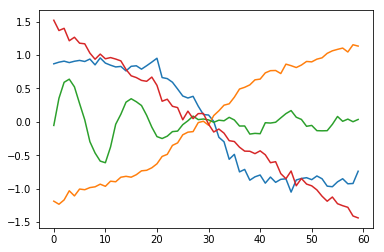

In [49]:
# plot
cl_obj.plot_centroids()

In [15]:
assigned_data = cl_obj.get_assignments()
# assigned_data: dictionary of 4 labels 0-3 (keys) with 600 values in them total 
# each value stands in for a row representing ts data 
assigned_data.keys()

dict_keys([1, 3, 2, 0])

In [29]:
for key, value in assigned_data.items():
    print("The number of items in this category are: ")
    print(len(assigned_data[key]))
    print("The first number is: ")
    print(assigned_data[key][0])

The number of items in this category are: 
30
The first number is: 
2
The number of items in this category are: 
168
The first number is: 
4
The number of items in this category are: 
199
The first number is: 
101
The number of items in this category are: 
199
The first number is: 
151


In [20]:
len(assigned_data[key])

199

## Prepare products dataframe for time warping

In [11]:
# prepare products df for timewarping
# flip it for duynamic time warping
# make 1223 rows x 240 time periods
products_df = products.T
products_df.head()

EntDate,2012-04-08 00:00:00,2012-04-15 00:00:00,2012-04-22 00:00:00,2012-04-29 00:00:00,2012-05-06 00:00:00,2012-05-13 00:00:00,2012-05-20 00:00:00,2012-05-27 00:00:00,2012-06-03 00:00:00,2012-06-10 00:00:00,...,2016-09-04 00:00:00,2016-09-11 00:00:00,2016-09-18 00:00:00,2016-09-25 00:00:00,2016-10-02 00:00:00,2016-10-09 00:00:00,2016-10-16 00:00:00,2016-10-23 00:00:00,2016-10-30 00:00:00,2016-11-06 00:00:00
017,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0300ST1550-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0300ST245-1,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
0300ST320-1,0,0,0,0,0,0,0,0,0,0,...,3,0,0,1,0,3,0,0,0,0
0300ST320-2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [12]:
# turn it into numpy array
import numpy as np

data_arr = np.asarray(products_df)
type(data_arr)
data_arr.shape

(1223, 240)

In [13]:
# timewarp!!!!

from ts_cluster import ts_cluster
import random
import numpy as np
from math import sqrt

cl_obj=ts_cluster(8)
cl_obj.k_means_clust(data_arr,10,4, progress=True)

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10


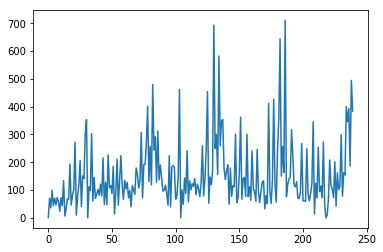

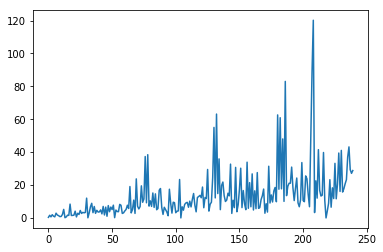

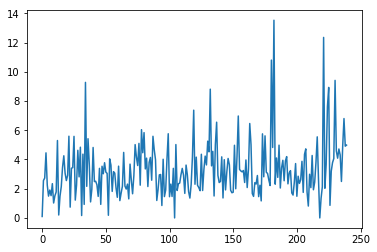

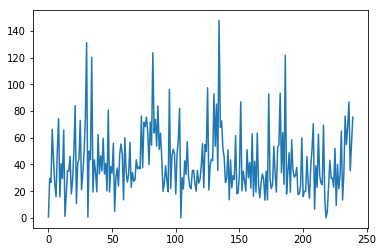

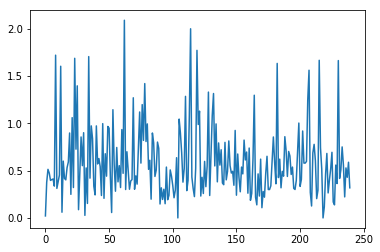

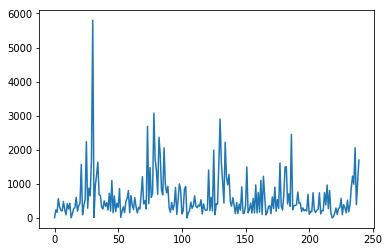

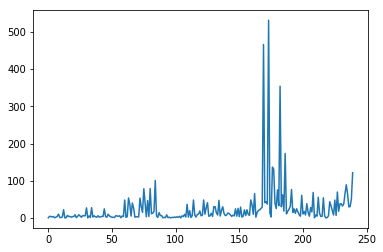

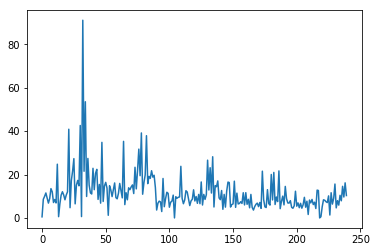

In [21]:
# plot it! save plot to send to Lee as an image
cl_obj.plot_centroids()

import matplotlib.pyplot as plt

In [33]:
# save results
import csv
 
assigned_data = cl_obj.get_assignments()
w = csv.writer(open("output.csv", "w"))
for key, val in assigned_data.items():
    w.writerow([key, val])
    
f = open("dict.txt","w")
f.write( str(assigned_data) )
f.close()
len(assigned_data[0]) # 73
len(assigned_data[1]) # 85
len(assigned_data[2]) # 366
len(assigned_data[3]) # 156
len(assigned_data[4]) # 333
len(assigned_data[5]) # 12
len(assigned_data[6]) # 27
len(assigned_data[7]) # 163

163

In [ ]:
# turn them back into product groups

# initial data panda df, name: products, columns=datetime, index=product SKUS
# turned into np.ndarray, name: data_arr, same as df without index names and column names

# create a list for all 8 keys
group_1 = []
group_2 = []
group_3 = []
group_4 = []
group_5 = []
group_6 = []
group_7 = []
group_8 = []

for key, value in assigned_data.items():
    # use assigned_data.values() as row numbers to find product SKUs in index
    
    # add corresponding product SKUs to lists
    group_1.append()
    
# output: 8 lists of products

## Select single item for forecasting

In [ ]:
# pick one item from each category
test = train_df['03108627CC']

In [ ]:
# plot one item
from functions import plot_train_test
plot_train_test(train_df, test_df, '03108627CC')